# Model Iteration 2 for Titanic Dataset

This model takes some queues from several different sources, combined into one supermodel! Kind of. I took some cool ideas from Elena Cuoco, who wrote a blog post on this specific dataset. I primarily looked at some feature engineering tactics she used. On the algorithmic side, I implemented something similar to the 'improving you submisson' DataQuest tutorial, which used a combination of logistic regression and random forests to predict survival.

First, imports!

In [81]:
from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier
import pandas
import re
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import KFold
from sklearn import cross_validation
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
import string

I've started off by defining a data cleaning convenience method, so I won't have to duplicate code later when dealing with the test set.

In [82]:
def clean_data(df):
    
    # Encoders to be used later to make converting categories to numerical representations easier
    label_encoder = preprocessing.LabelEncoder()
    one_hot_encoder = preprocessing.OneHotEncoder()
    
    # Replace 'male' 'Sex' with 0, 'female' 'Sex' with 1
    df.loc[df['Sex'] == 'male', 'Sex'] = 0
    df.loc[df['Sex'] == 'female', 'Sex'] = 1
    
    # Setting likely wrong values to nan
    df.Fare = df.Fare.map(lambda x: np.nan if x==0 else x)
    
    title_list=['Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev',
            'Dr', 'Ms', 'Mlle','Col', 'Capt', 'Mme', 'Countess',
            'Don', 'Jonkheer']
    
    df['Title']=df['Name'].map(lambda x: substrings_in_string(x, title_list))
    
    # Collapse all titles into four main categories - Mr, Mrs, Master, and Miss
    def replace_titles(x):
        title=x['Title']
        if title in ['Mr','Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col']:
            return 'Mr'
        elif title in ['Master']:
            return 'Master'
        elif title in ['Countess', 'Mme','Mrs']:
            return 'Mrs'
        elif title in ['Mlle', 'Ms','Miss']:
            return 'Miss'
        elif title =='Dr':
            if x['Sex']=='Male':
                return 'Mr'
            else:
                return 'Mrs'
        elif title =='':
            if x['Sex']=='Male':
                return 'Master'
            else:
                return 'Miss'
        else:
            return title
        
    df['Title']=df.apply(replace_titles, axis=1)
    
    #Creating new family_size column
    df['Family_Size']=df['SibSp']+df['Parch']
    df['Family']=df['SibSp']*df['Parch']

    # Replace 'Embarked' NaN with most popular 'Embarked', 'S'
    df['Embarked'] = df['Embarked'].fillna('S')
    
    # Replace 'Embarked' values with numeric values 0-2
    df.loc[df['Embarked'] == 'S', 'Embarked'] = 0
    df.loc[df['Embarked'] == 'C', 'Embarked'] = 1
    df.loc[df['Embarked'] == 'Q', 'Embarked'] = 2
    
    # Imputing Nan values in fare based on median values for each class
    df.loc[ (df.Fare.isnull())&(df.Pclass==1),'Fare'] =np.median(df[df['Pclass'] == 1]['Fare'].dropna())
    df.loc[ (df.Fare.isnull())&(df.Pclass==2),'Fare'] =np.median( df[df['Pclass'] == 2]['Fare'].dropna())
    df.loc[ (df.Fare.isnull())&(df.Pclass==3),'Fare'] = np.median(df[df['Pclass'] == 3]['Fare'].dropna())
    
    # Trying to improve upon the base 'Age' filling median
    df['AgeFill']=df['Age']
    mean_ages = np.zeros(4)
    mean_ages[0]=np.average(df[df['Title'] == 'Miss']['Age'].dropna())
    mean_ages[1]=np.average(df[df['Title'] == 'Mrs']['Age'].dropna())
    mean_ages[2]=np.average(df[df['Title'] == 'Mr']['Age'].dropna())
    mean_ages[3]=np.average(df[df['Title'] == 'Master']['Age'].dropna())
    df.loc[ (df.Age.isnull()) & (df.Title == 'Miss') ,'AgeFill'] = mean_ages[0]
    df.loc[ (df.Age.isnull()) & (df.Title == 'Mrs') ,'AgeFill'] = mean_ages[1]
    df.loc[ (df.Age.isnull()) & (df.Title == 'Mr') ,'AgeFill'] = mean_ages[2]
    df.loc[ (df.Age.isnull()) & (df.Title == 'Master') ,'AgeFill'] = mean_ages[3]

    # Creating a new category 'AgeCat'
    df['AgeCat'] = df['AgeFill']
    df.loc[ (df.AgeFill<=10) ,'AgeCat'] = 'child'
    df.loc[ (df.AgeFill>60),'AgeCat'] = 'aged'
    df.loc[ (df.AgeFill>10) & (df.AgeFill <=30) ,'AgeCat'] = 'adult'
    df.loc[ (df.AgeFill>30) & (df.AgeFill <=60) ,'AgeCat'] = 'senior'
    
    label_encoder.fit(df['AgeCat'])
    x_age = label_encoder.transform(df['AgeCat'])
    df['AgeCat'] = x_age.astype(np.float)
    
    label_encoder.fit(df['Title'])
    x_title=label_encoder.transform(df['Title'])
    df['Title'] =x_title.astype(np.float)    
    
    df['Fare_Per_Person']=df['Fare']/(df['Family_Size']+1)
    
    return df

    
# Utility to clean data
def substrings_in_string(big_string, substrings):
    for substring in substrings:
        if string.find(big_string, substring) != -1:
            return substring
    print big_string
    return np.nan
    

Now, I'll use the above cleaning function to clean up the training data set and generate new columns.

In [71]:
titanic = pandas.read_csv("train.csv")

titanic = clean_data(titanic)

Next, I'll try tuning some parameters on the random forest model. I'm specifically looking at n_estimators, min_samples_split, and min_samples_leaf.

In [94]:
predictors = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 'Title', 'Family_Size', 'Family', 'AgeFill', 'AgeCat', 'Fare_Per_Person']

alg = RandomForestClassifier(random_state=1, n_estimators=150, min_samples_split=4, min_samples_leaf=2)

scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv=3)

# Take the mean of the scores (because we have one for each fold)
print(scores.mean())

0.83164983165


This is a little worrying - while Random Forests seems appropriate for a use like this where there may be a number of predictors with relatively unknown weight, I think I'm probably overfitting quite a bit to the training set. This makes me a little hesitant to continue, but I imagine I'll end up somewhere in the 79% range.

Next, I'll leverage some features of scikit learn to select the most predictive features.

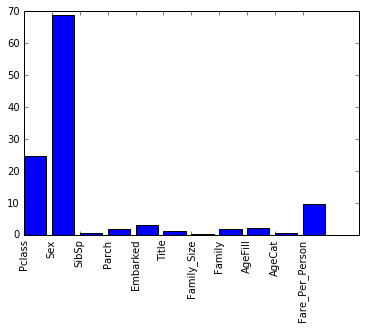

0.821548821549


In [73]:
%matplotlib inline

predictors = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 'Title', 'Family_Size', 'Family', 'AgeFill', 'AgeCat', 'Fare_Per_Person']

selector = SelectKBest(f_classif, k=5)
selector.fit(titanic[predictors], titanic['Survived'])

scores = -np.log10(selector.pvalues_)

plt.bar(range(len(predictors)), scores)
plt.xticks(range(len(predictors)), predictors, rotation='vertical')
plt.show()

predictors = ['Pclass', 'Sex', 'Fare', 'Title']

alg = RandomForestClassifier(random_state=1, n_estimators=150, min_samples_split=8, min_samples_leaf=4)

scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic['Survived'], cv=3)

print(scores.mean())

Let's do some ensembling!

In [96]:
algorithms = [
    [GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3), ["Pclass", "Sex", "AgeFill", "Fare", "Embarked", "Family_Size", "Title"]],
    [LogisticRegression(random_state=1), ["Pclass", "Sex", "Fare", "Family_Size", "Title", "AgeFill", "Embarked", "AgeCat"]]
]

# Initialize the cross validation folds
kf = KFold(titanic.shape[0], n_folds=3, random_state=1)

predictions = []
for train, test in kf:
    train_target = titanic["Survived"].iloc[train]
    full_test_predictions = []
    # Make predictions for each algorithm on each fold
    for alg, predictors in algorithms:
        # Fit the algorithm on the training data.
        alg.fit(titanic[predictors].iloc[train,:], train_target)
        # Select and predict on the test fold.  
        # The .astype(float) is necessary to convert the dataframe to all floats and avoid an sklearn error.
        test_predictions = alg.predict_proba(titanic[predictors].iloc[test,:].astype(float))[:,1]
        full_test_predictions.append(test_predictions)
    # Use a simple ensembling scheme -- just average the predictions to get the final classification.
    test_predictions = (full_test_predictions[0] + full_test_predictions[1]) / 2
    # Any value over .5 is assumed to be a 1 prediction, and below .5 is a 0 prediction.
    test_predictions[test_predictions <= .5] = 0
    test_predictions[test_predictions > .5] = 1
    predictions.append(test_predictions)

# Put all the predictions together into one array.
predictions = np.concatenate(predictions, axis=0)

# Compute accuracy by comparing to the training data.
accuracy = sum(predictions[predictions == titanic["Survived"]]) / len(predictions)
print(accuracy)

0.817059483726


/home/patrick/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:32: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


Now time to match these same changes on the test set.

In [77]:
titanic_test = pandas.read_csv('test.csv')

titanic_test = clean_data(titanic_test)

# Making sure there aren't any NaN values
titanic_test.count()

PassengerId        418
Pclass             418
Name               418
Sex                418
Age                332
SibSp              418
Parch              418
Ticket             418
Fare               418
Cabin               91
Embarked           418
Title              418
Family_Size        418
Family             418
AgeFill            418
AgeCat             418
Fare_Per_Person    418
dtype: int64

And now it's time to predict and make a submission!

In [85]:
predictors = ["Pclass", "Sex", "Age", "Fare", "Embarked", "FamilySize", "Title", "FamilyId"]


algorithms = [
    [GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3), ["Pclass", "Sex", "AgeFill", "Fare", "Embarked", "Family_Size", "Title", "AgeCat"]],
    [LogisticRegression(random_state=1), ["Pclass", "Sex", "Fare", "Family_Size", "Title", "AgeFill", "Embarked", "AgeCat"]]
]

full_predictions = []
for alg, predictors in algorithms:
    # Fit the algorithm using the full training data.
    alg.fit(titanic[predictors], titanic["Survived"])
    # Predict using the test dataset.  We have to convert all the columns to floats to avoid an error.
    predictions = alg.predict_proba(titanic_test[predictors].astype(float))[:,1]
    full_predictions.append(predictions)

# The gradient boosting classifier generates better predictions, so we weight it higher.
predictions = (full_predictions[0] * 3 + full_predictions[1]) / 4
predictions[predictions <= .5] = 0
predictions[predictions > .5] = 1
predictions = predictions.astype(int)
submission = pandas.DataFrame({
        "PassengerId": titanic_test["PassengerId"],
        "Survived": predictions
    })

submission.to_csv("kaggleForestHalfNew2.csv", index=False)

After several submissions, and lots of experimenting with different types of feature engineering, parameter tuning on the random forests, and some other assorted tricks, I topped out at ~79%. Even after I did a good amount of research into what extra feature engineering would help me out, my score ended up decreasing (not significantly, I simply predicted one fewer person correctly).

Upon this, I did more research into random forests, and learned pretty quickly that they are very prone to overfitting. Here's an excerpt taken from a list of disadvantages scikit-learn mentions about decision trees and random forests -

"Decision-tree learners can create over-complex trees that do not generalise the data well. This is called overfitting. Mechanisms such as pruning (not currently supported), setting the minimum number of samples required at a leaf node or setting the maximum depth of the tree are necessary to avoid this problem."

Here are some notes/thoughts I've come across on Random Trees, Gradient Boosted, etc.

Algorithmically, what's the difference?

Random Forests are trained with random sample of data (even more randomized cases available like feature randomization) and it trusts randomization to have better generalization performance on out of train set.
On the other spectrum, Gradient Boosted Trees algorithm additionally tries to find optimal linear combination of trees (assume final model is the weighted sum of predictions of individual trees) in relation to given train data. This extra tuning might be deemed as the difference. Note that, there are many variations of those algorithms as well.

Practicallly, what's the difference?

Due to the extra necessary tuning stage, Gradient Boosted Trees are more susceptible to jiggling data. This final stage makes GBT more likely to overfit therefore if the test cases are inclined to be so verbose compared to train cases this algorithm starts lacking. On the contrary, Random Forests are better to strain on overfitting although it is lacking on the other way around.

Two takeaways, then:

1. RF are much easier to tune than GBM
2. RF are harder to overfit than GBM

Given this, perhaps I should have ended up using the RF in my combination - I don't feel like I have enough experience to make an informed decision on tuning parameters, so perhaps I'll just use a Random Forest, which c

In [98]:
algorithms = [
    [RandomForestClassifier(random_state=1, n_estimators=150, min_samples_split=4, min_samples_leaf=2), ["Pclass", "Sex", "AgeFill", "Fare", "Embarked", "Family_Size", "Title", "AgeCat"]],
    [LogisticRegression(random_state=1), ["Pclass", "Sex", "Fare", "Family_Size", "Title", "AgeFill", "Embarked", "AgeCat"]]
]

full_predictions = []
for alg, predictors in algorithms:
    # Fit the algorithm using the full training data.
    alg.fit(titanic[predictors], titanic["Survived"])
    # Predict using the test dataset.  We have to convert all the columns to floats to avoid an error.
    predictions = alg.predict_proba(titanic_test[predictors].astype(float))[:,1]
    full_predictions.append(predictions)

# The gradient boosting classifier generates better predictions, so we weight it higher.
predictions = (full_predictions[0] * 3 + full_predictions[1]) / 4
predictions[predictions <= .5] = 0
predictions[predictions > .5] = 1
predictions = predictions.astype(int)
submission = pandas.DataFrame({
        "PassengerId": titanic_test["PassengerId"],
        "Survived": predictions
    })

submission.to_csv("kaggleRFLogistic.csv", index=False)

After losing another percentage of accuracy, bringing me down to 78%, I've decided to call it a day. Perhaps with enough parameter tuning, I could get it to increase, but I think this is exposing limitations of my feature engineering. If I were to continue to work on this, feature engineering would be one of my first areas of attack - only then would I start exploring different models, or perhaps tuning the ones I've been dealing with thus far - logistic regression, random forests, and gradient boosted trees.